AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

Sl_No: Primary key of the records
Customer Key: Customer identification number
Average Credit Limit: Average credit limit of each customer for all credit cards
Total credit cards: Total number of credit cards possessed by the customer
Total visits bank: Total number of visits that customer made (yearly) personally to the bank
Total visits online: Total number of visits or online logins made by the customer (yearly)
Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

In [2]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

* The dataset has 660 rows and 7 columns

In [4]:
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [5]:
df = data.copy()

<IPython.core.display.Javascript object>

In [6]:
df.drop("Sl_No", axis=1, inplace=True)


<IPython.core.display.Javascript object>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


<IPython.core.display.Javascript object>

**Observations**

- All variables are numerical.
- There are no null values.

In [8]:
df.describe()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

**Observations**

- The mean value of credit limit is ~35000, indicating that most customers have high credit.
- Over 75% of customers have 6 credit cards.

In [9]:
df.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

* There are no null values 

In [10]:
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

* There are no duplicate values 

# EDA

In [11]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

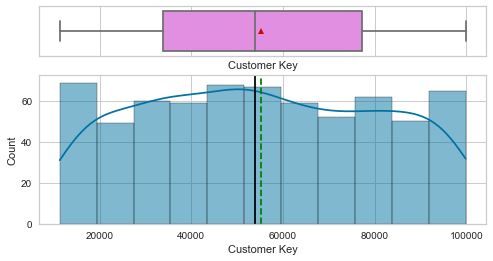

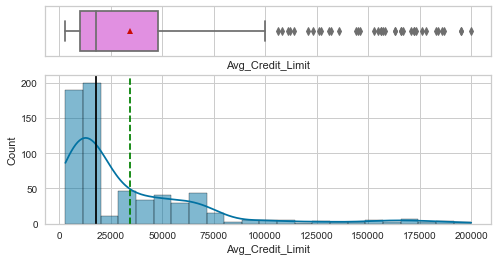

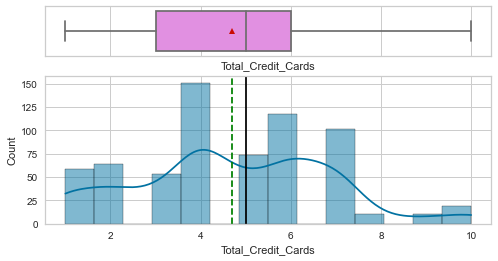

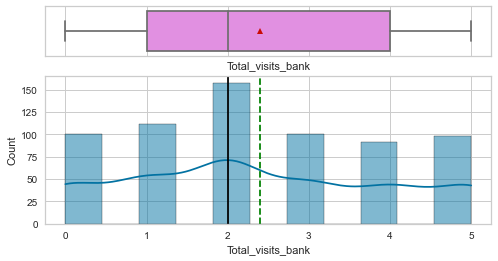

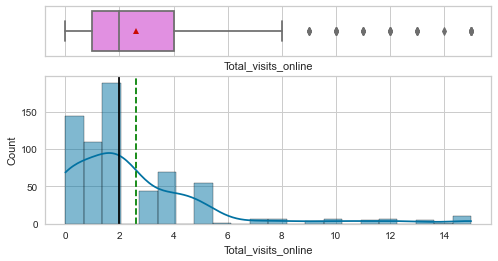

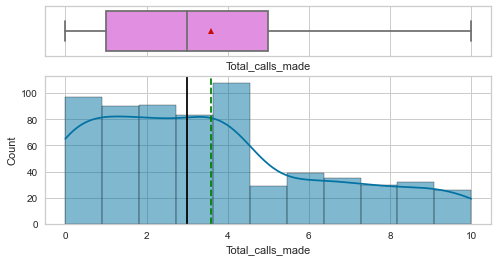

<IPython.core.display.Javascript object>

In [12]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

**Observations**

- 50% of customer haveat least 5 crdit cards.
- At least 50% of the customers have made 2 bank visits.

In [13]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

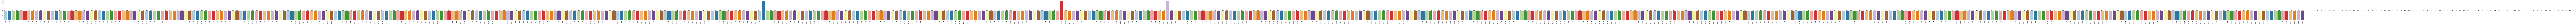

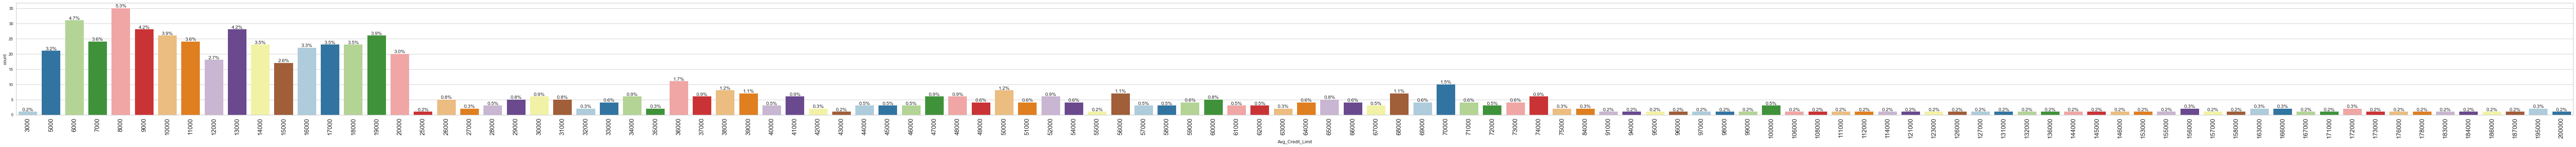

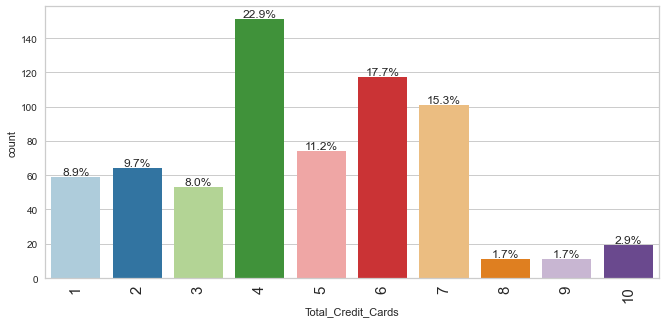

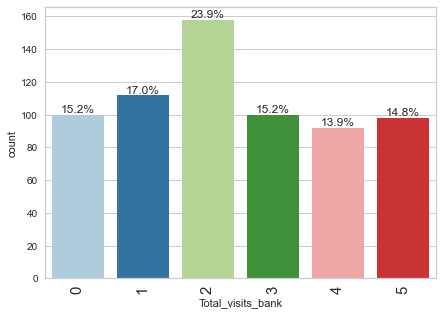

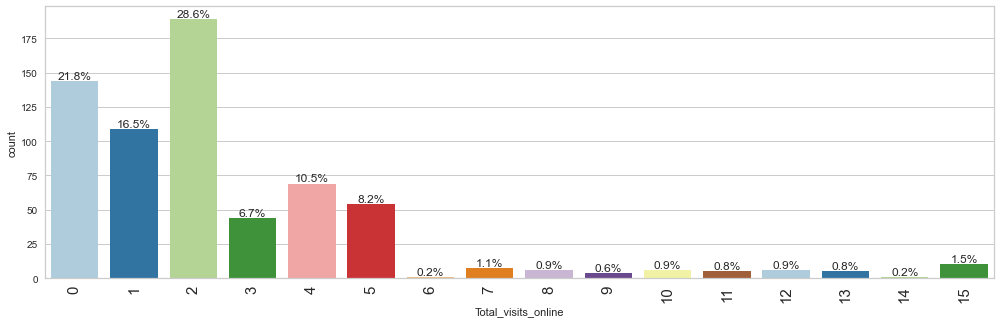

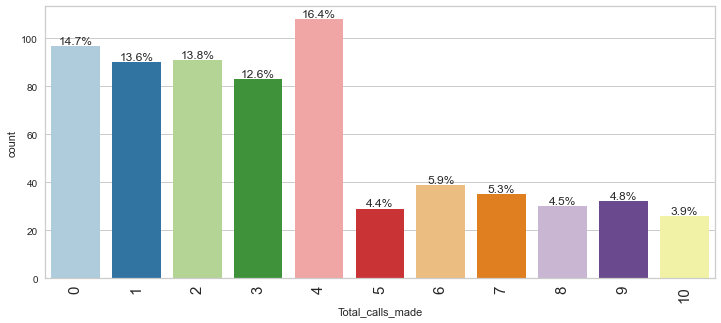

<IPython.core.display.Javascript object>

In [14]:
for item in num_col:
    labeled_barplot(df, item, perc=True)

**Observations**

- Most customers have visited the online site less than 5 times .
- CLose to 70% of customers made 4 calls or less..

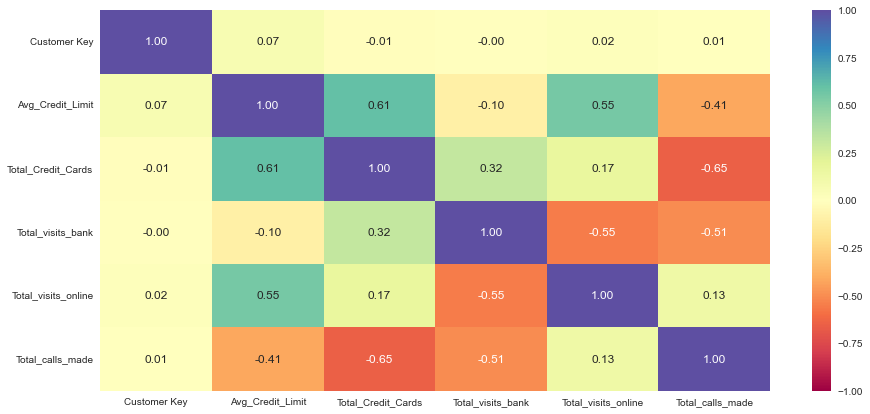

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- There is no strong correlation between the variables

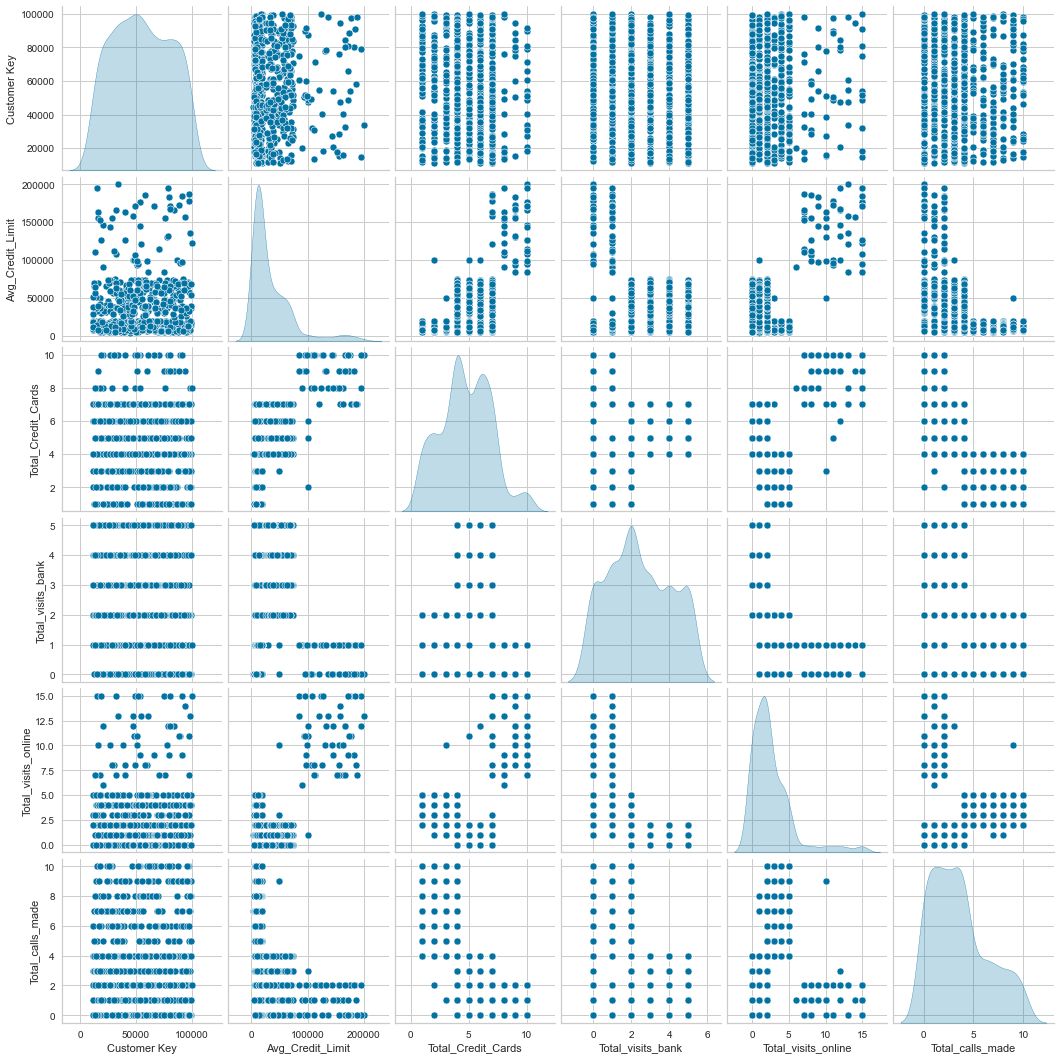

<IPython.core.display.Javascript object>

In [16]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

In [17]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [18]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  "KMeans is known to have a memory leak on Windows "


Number of Clusters: 1 	Average Distortion: 2.2569539857353345
Number of Clusters: 2 	Average Distortion: 1.7858322163326599
Number of Clusters: 3 	Average Distortion: 1.505531485649799
Number of Clusters: 4 	Average Distortion: 1.363222352950455
Number of Clusters: 5 	Average Distortion: 1.2726936504945592
Number of Clusters: 6 	Average Distortion: 1.2193964526252834
Number of Clusters: 7 	Average Distortion: 1.179825674457407
Number of Clusters: 8 	Average Distortion: 1.1451767813291247


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

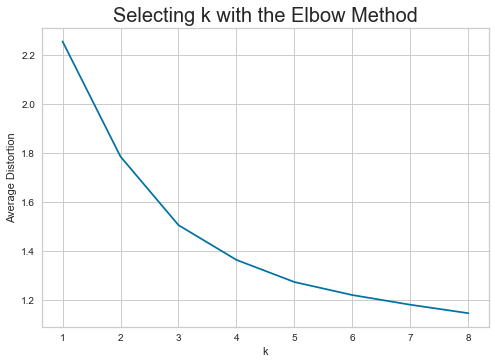

<IPython.core.display.Javascript object>

In [19]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 or 4.**

For n_clusters = 2, silhouette score is 0.33817196365464486
For n_clusters = 3, silhouette score is 0.4177434852377372
For n_clusters = 4, silhouette score is 0.3228907072652812
For n_clusters = 5, silhouette score is 0.2850863954249504
For n_clusters = 6, silhouette score is 0.25413205265109257
For n_clusters = 7, silhouette score is 0.23772977329812314
For n_clusters = 8, silhouette score is 0.22874350768026966
For n_clusters = 9, silhouette score is 0.20793455663228996


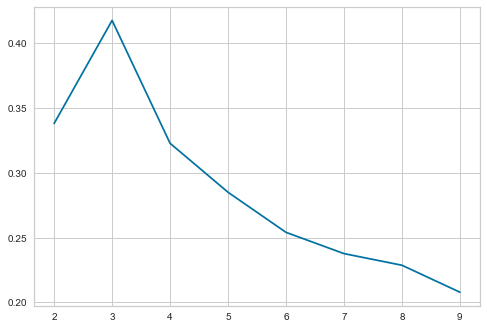

<IPython.core.display.Javascript object>

In [20]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

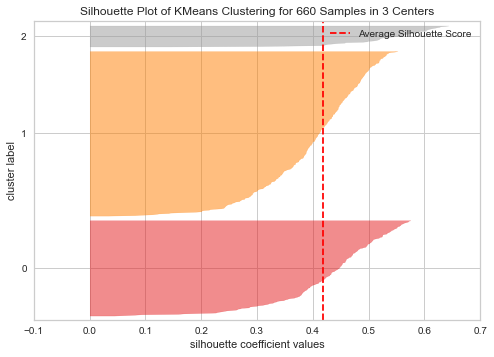

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [21]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

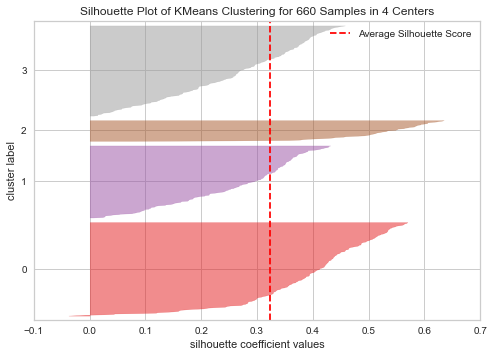

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [22]:
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

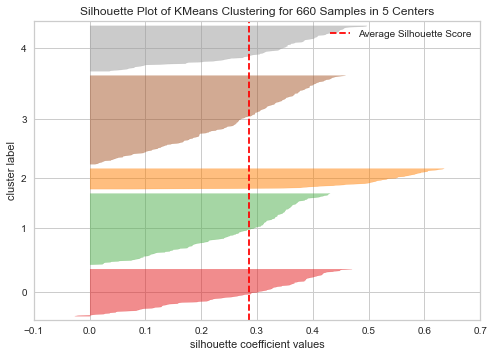

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [23]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

**Let's take 4 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 4 in the elbow curve.**

In [24]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=0)

<IPython.core.display.Javascript object>

In [25]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [26]:
cluster_profile = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [27]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,,
0,79136.872093,37651.162791,5.593023,3.523256,0.941860,1.936047
1,35299.195349,30618.604651,5.446512,3.455814,1.027907,2.060465
2,55412.762332,12143.497758,2.403587,0.928251,3.551570,6.883408
3,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000


<IPython.core.display.Javascript object>

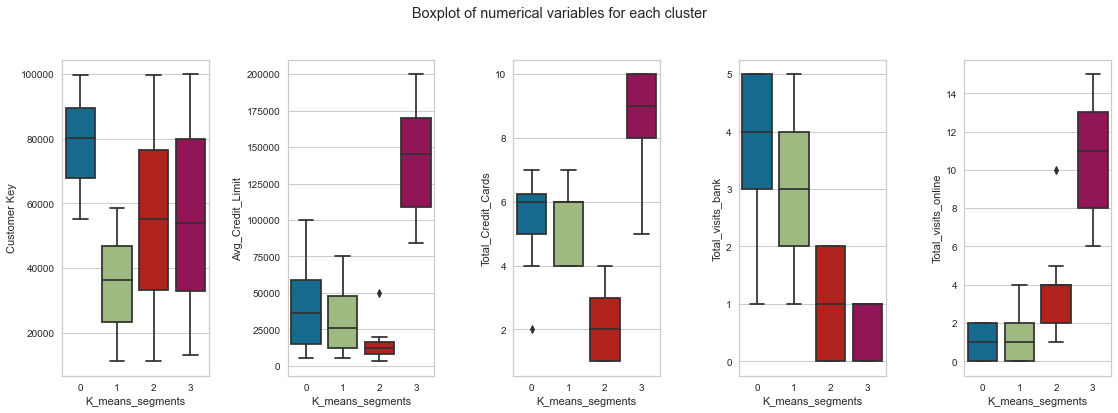

<IPython.core.display.Javascript object>

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - Avergae credit limit is low
    - Total Credit cards is average(4-6).
    - Totl no. ofvisits to the bank is high.
    - Total no. of online visits is low.
  


- **Cluster 1**:
    - Avergae credit limit is low
    - Total Credit cards is average(4-6).
    - Totl no. ofvisits to the bank is average.
    - Total no. of online visits is low.


- **Cluster 2**:
    - Avergae credit limit is low
    - Total Credit cards is low.
    - Totl no. ofvisits to the bank is low.
    - Total no. of online visits is low.


- **Cluster 3**:
    - Avergae credit limit is low
    - Total Credit cards is high(8-10).
    - Totl no. ofvisits to the bank is low.
    - Total no. of online visits is high.



In [29]:
# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>

## Hierarchical Clustering

In [30]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.715826147503084.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8333358686900459.
Cophenetic correlation for Euclidean distance and average linkage is 0.8684228720933057.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8642251666438747.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6993328509872334.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7832281429250633.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8628342866871905.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8345913036690694.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6829750720107935.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.605131678497462.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7754307051655684.
Cophenetic corr

<IPython.core.display.Javascript object>

In [31]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8684228720933057, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

In [32]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.715826147503084.
Cophenetic correlation for complete linkage is 0.8333358686900459.
Cophenetic correlation for average linkage is 0.8684228720933057.
Cophenetic correlation for centroid linkage is 0.8656427328161594.
Cophenetic correlation for ward linkage is 0.7067190998109724.
Cophenetic correlation for weighted linkage is 0.8642251666438747.


<IPython.core.display.Javascript object>

In [33]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8684228720933057, which is obtained with average linkage.


<IPython.core.display.Javascript object>

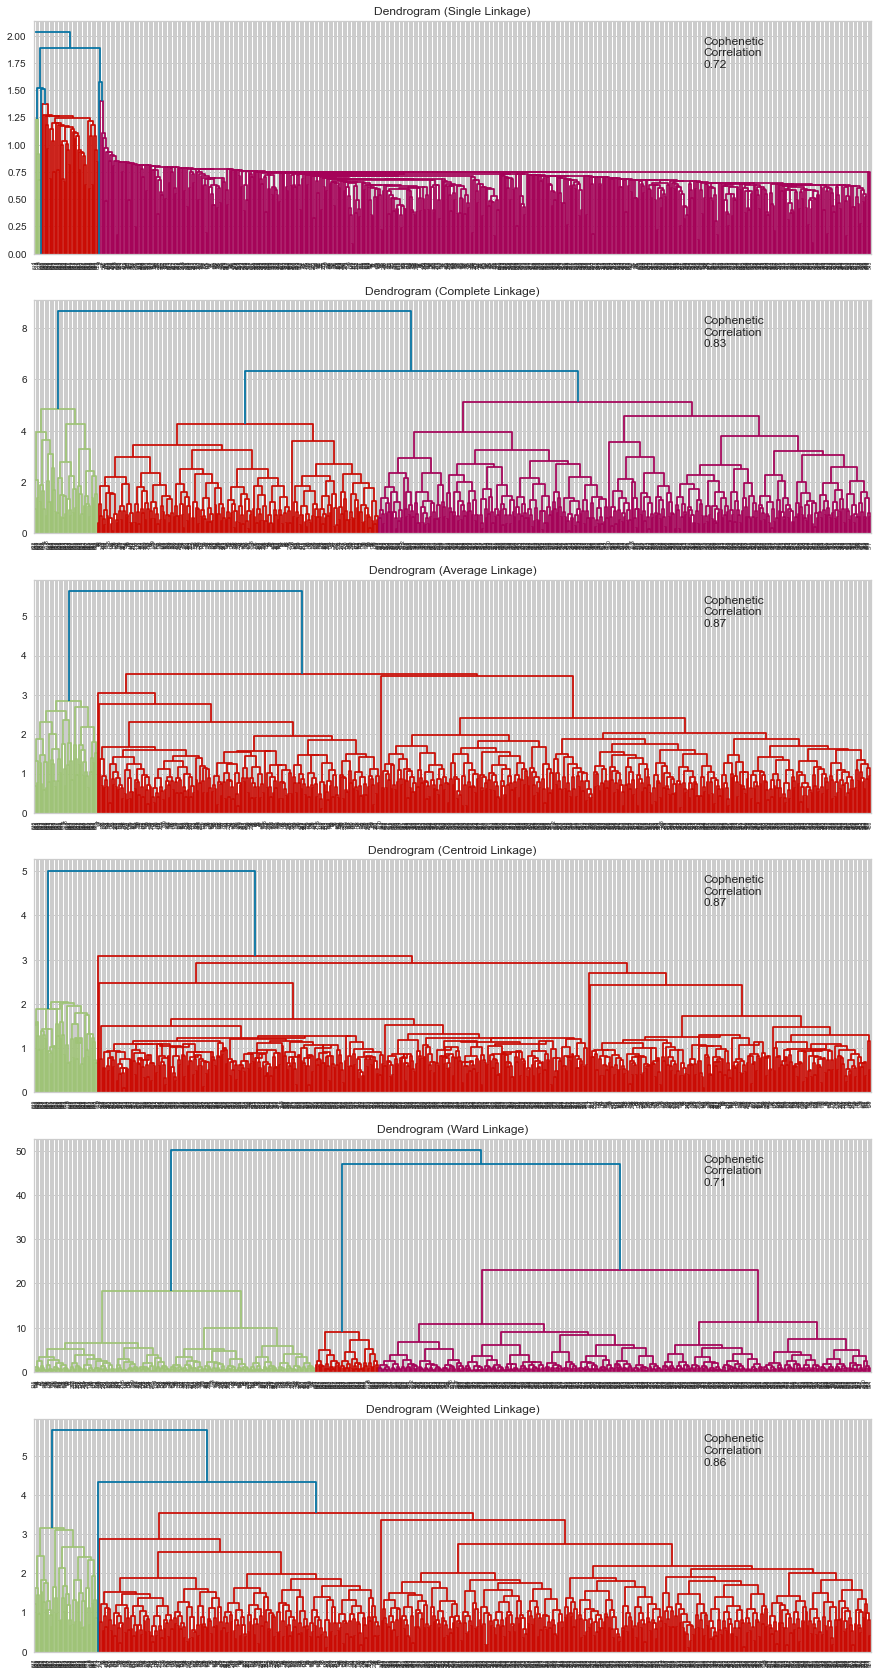

<IPython.core.display.Javascript object>

In [34]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average linkage methods.
- 6 appears to be the appropriate number of clusters from the dendrogram for average linkage.

In [35]:
HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=6)

<IPython.core.display.Javascript object>

In [36]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

In [37]:
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [38]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [39]:
for cl in df["HC_Clusters"].unique():
    print("In cluster {}, the following customers are present:".format(cl))
    print(df[df["HC_Clusters"] == cl]["Customer Key"].unique())
    print()

In cluster 3, the following customers are present:
[87073]

In cluster 4, the following customers are present:
[38414]

In cluster 5, the following customers are present:
[17341 40496 52363 54838 35254 46635 97825 83125 35483 15129 83290 56486
 31903 45909 14263 46813 81878 35549 85799 39122 81531 69965 18595 44398
 32352 40898 27101 33457 45088 23302 27408 65372 21531 56843 17165 89328
 20072 71402 47496 24808 17036 67193 34423 97109 55382 51811 53936 66504
 53207 18514 51319 36340 36934 95925 49771 22919 21233 74544 52025 45652
 73952 49418 77026 49331 75775 54906 94666 11698 34677 95610 41380 38033
 85337 38994 67911 92956 77641 57565 53814 30712 19785 31384 16374 50878
 78002 83459 91987 51552 24998 45673 11596 87485 28414 81863 33240 11466
 23881 44645 49844 92782 22824 26767 26678 50412 17933 34495 47437 22610
 41159 64672 62483 85614 96548 19137 69028 70779 38244 67046 64897 46223
 36628 17565 77381 11799 81940 66706 87838 94437 33790 44402 29886 66804
 47866 61996 15318 89635 7

<IPython.core.display.Javascript object>

**We see that there are 2 clusters of one customer, 1 cluster with 19 customers and 1 with 31 customers . All the other customers are grouped into 2 clusters.**

In [40]:
HCmodel = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(n_clusters=6)

<IPython.core.display.Javascript object>

In [41]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

In [42]:
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [43]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [50]:
# let's see the names of the Customers in each cluster
for cl in df["HC_Clusters"].unique():
    print(
        "The",
        df[df["HC_Clusters"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(df[df["HC_Clusters"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 152 customers in cluster 0 are:
[87073 54838 97825 83125 83290 81878 85799 81531 56843 89328 71402 67193
 97109 66504 95925 74544 73952 77026 75775 54906 94666 95610 85337 67911
 92956 77641 78002 83459 91987 87485 81863 92782 47437 64672 62483 85614
 96548 69028 70779 67046 77381 81940 66706 87838 94437 66804 61996 89635
 71681 71862 96186 88807 82376 98126 80347 62807 92522 61994 72431 85122
 55478 96929 78912 68439 62864 77954 88207 78618 75792 97954 90189 88884
 92140 88123 87456 97530 76209 61122 82807 93496 96297 87219 65747 81166
 70707 84351 89446 94595 92489 92933 70101 77613 84360 67258 65781 74446
 76024 75065 95147 76957 61324 77826 61216 83192 82023 73000 90131 94529
 81910 76492 99131 99437 91242 90860 69868 83585 68040 75417 85645 83545
 75398 90999 80942 97850 79885 83466 81510 88411 96269 87683 58116 67282
 84888 96534 68920 67637 90586 87670 76398 93310 94700 99473 68862 93381
 74083 72339 99284 67415 58276 85234 90191 80623]
--------------------------------------

<IPython.core.display.Javascript object>

**Now the clusters seem to have more variability.**

In [51]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,,
0,80783.869281,34653.594771,5.581699,3.516340,0.947712,1.803922,0.032680,153
1,76498.947826,12226.086957,2.095652,0.930435,3.478261,6.878261,2.000000,115
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,3.000000,50
3,29589.007576,26378.787879,5.439394,3.916667,0.931818,2.030303,0.984848,132
4,32575.383178,11728.971963,2.728972,0.934579,3.579439,6.869159,1.990654,107
5,48633.873786,41961.165049,5.475728,2.854369,1.203883,2.339806,0.805825,103


<IPython.core.display.Javascript object>

## Insights

- **Cluster 0**
   - There are 152 customers in this cluster.
   - The Average Credit limit for this cluster is low .
   - The total Credit cards for this cluster is average.
   - The tota visits to the back are average to above average.
   - The total online visits are low.
   - The total calls made are low.  
   
 
 - **Cluster 1**
   - There are 115 customers in this cluster.
   - The Average Credit limit for this cluster is very low .
   - The total Credit cards for this cluster is low.
   - The tota visits to the back are low.
   - The total online visits are low.
   - The total calls made are above average to high.
   
- **Cluster 2**
   - There are 50 customers in this cluster.
   - The Average Credit limit for this cluster is average to above average .
   - The total Credit cards for this cluster is high.
   - The tota visits to the back are low.
   - The total online visits are average to above average.
   - The total calls made are low.
   
- **Cluster 3**
   - There are 132 customers in this cluster.
   - The Average Credit limit for this cluster is low .
   - The total Credit cards for this cluster is average.
   - The tota visits to the back are average to above average.
   - The total online visits are low.
   - The total calls made are low.

- **Cluster 4**
   - There are 107 customers in this cluster.
   - The Average Credit limit for this cluster is very low .
   - The total Credit cards for this cluster is below average.
   - The tota visits to the back are low.
   - The total online visits are low.
   - The total calls made are high.

- **Cluster 5**
   - There are 103 customers in this cluster.
   - The Average Credit limit for this cluster is low .
   - The total Credit cards for this cluster is average.
   - The tota visits to the back are average.
   - The total online visits are low.
   - The total calls made are low.

## Recommendations

**Based on cluster profiling done above,**

**Cluster 2 customers are ideal to target for services as they have high credit limits and also already use a no. of services like credit cards**  

**Cluster 2 customers are also frequent online visit which means sales should be geared to the online site to capture these customers attention.**